In [10]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import json
#path = Path('../save_data/Classificatior_data/')
path = Path('Classificatior_data/')
if not path.exists():
    print("No data found in the specified path.")

In [11]:
import re

jsons = sorted(
    path.glob('*.json'),
    key=lambda f: int(re.search(r'v(\d+)', f.name).group(1))
)

print(f'Found {len(jsons)} JSON files in {path}')

histories = []
for json_file in jsons:
    print(f'Reading {json_file}')
    with open(json_file, 'r') as file:
        histories.append(file.read())


Found 1 JSON files in Classificatior_data
Reading Classificatior_data/history_v11.json


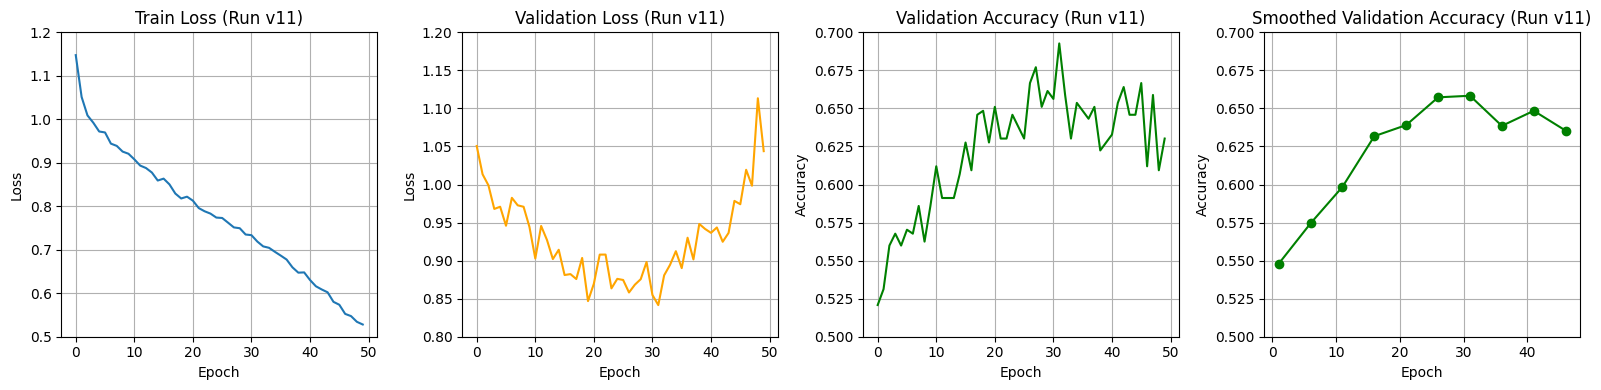

In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Grouped average function
def grouped_average(values, group_size):
    return [np.mean(values[i:i + group_size]) for i in range(0, len(values), group_size)]

group_size = 5  # average over 5 epochs

histories = []
versions = []

# Sort by version number 
jsons = sorted(
    path.glob('*.json'),
    key=lambda f: int(re.search(r'v(\d+)', f.name).group(1))
)

# Read data and record version numbers
for json_file in jsons:
    version = int(re.search(r'v(\d+)', json_file.name).group(1))
    versions.append(version)
    with open(json_file, 'r') as file:
        histories.append(json.loads(file.read()))

# Plot each history {''val_loss': {'min': 0.8415678544455053, 'max': 1.1133653283222884}, 'val_acc': {'min': 0.5208333333333334, 'max': 0.6927083333333334}}

for history, version in zip(histories, versions):
    val_acc = history['val_acc']
    val_acc_grouped = grouped_average(val_acc, group_size)
    val_acc_epochs = [i + 1 for i in range(0, len(val_acc), group_size)]

    plt.figure(figsize=(16, 4))

    # Loss
    plt.subplot(1, 4, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Train Loss (Run v{version})')  # Use real version number
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.ylim(0.5, 1.2)

    # Val loss
    plt.subplot(1, 4, 2)
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title(f'Validation Loss (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.ylim(0.8,1.2)

    plt.subplot(1, 4, 3)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0.5, 0.7)

    # Smoothed val accuracy
    plt.subplot(1, 4, 4)
    plt.plot(val_acc_epochs, val_acc_grouped, label='Val Acc (Avg/5)', color='green', marker='o')
    plt.title(f'Smoothed Validation Accuracy (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0.5, 0.7)
    
    plt.tight_layout()
    plt.show()


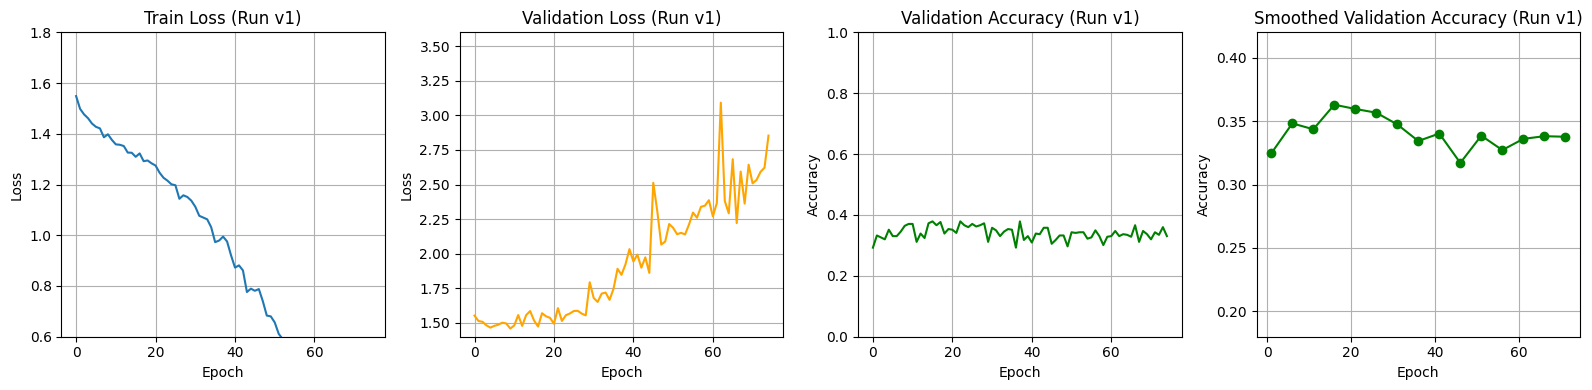

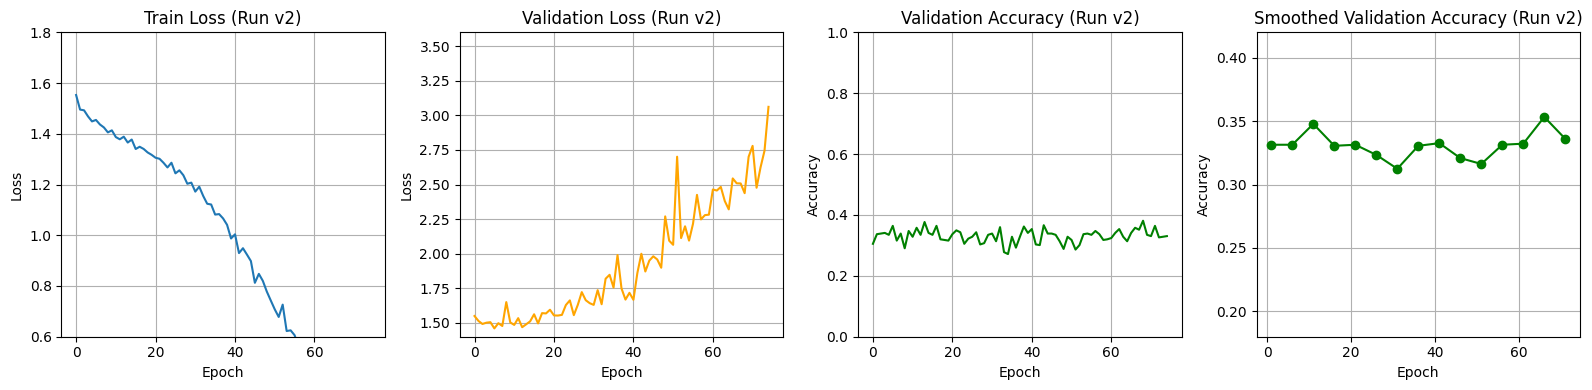

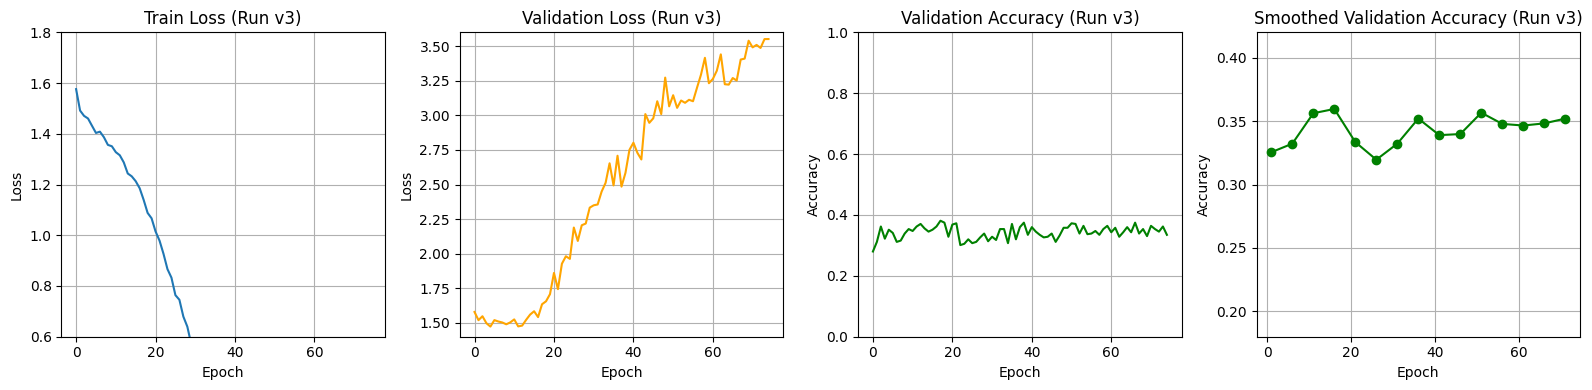

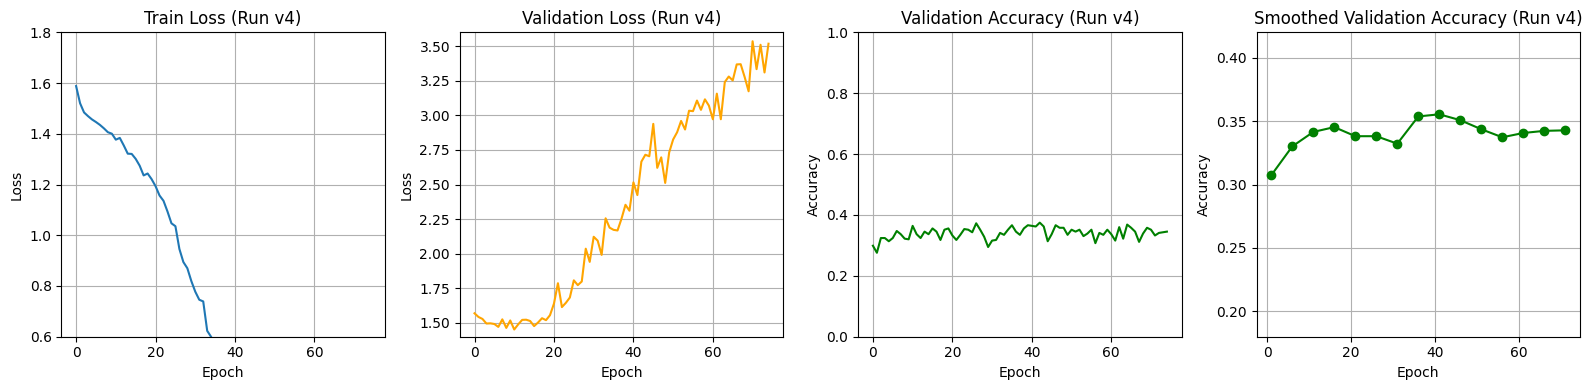

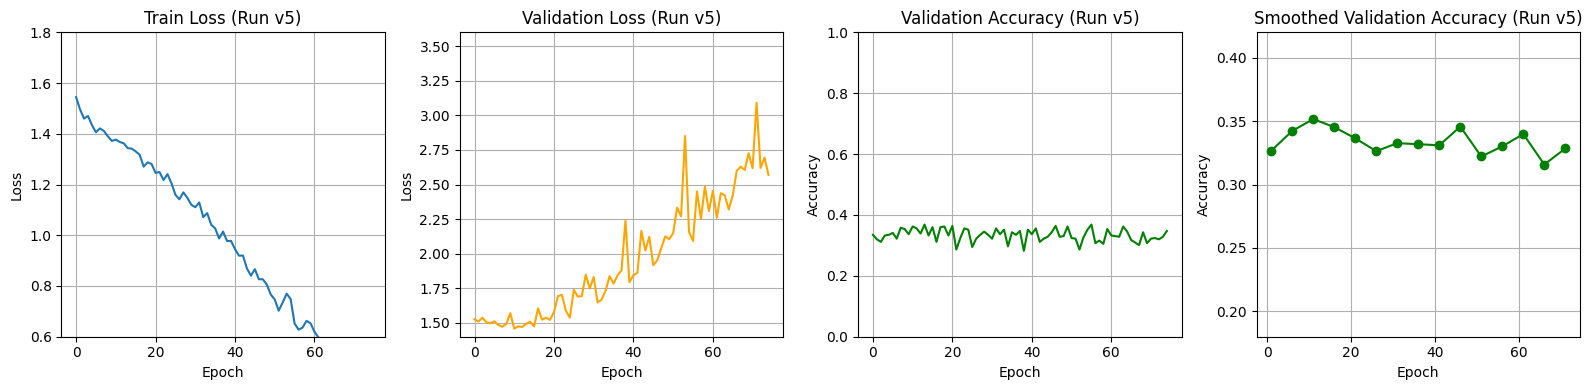

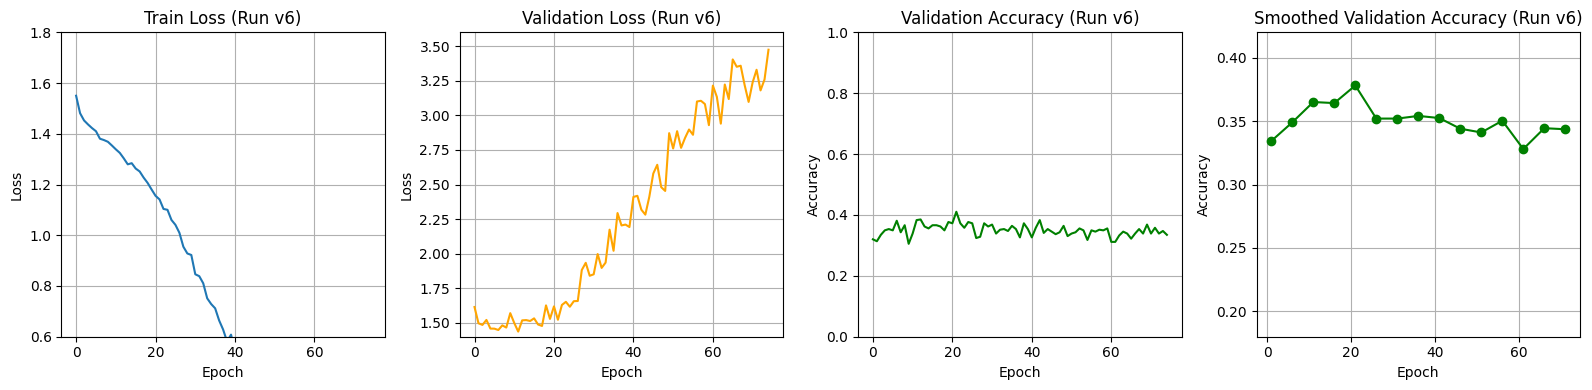

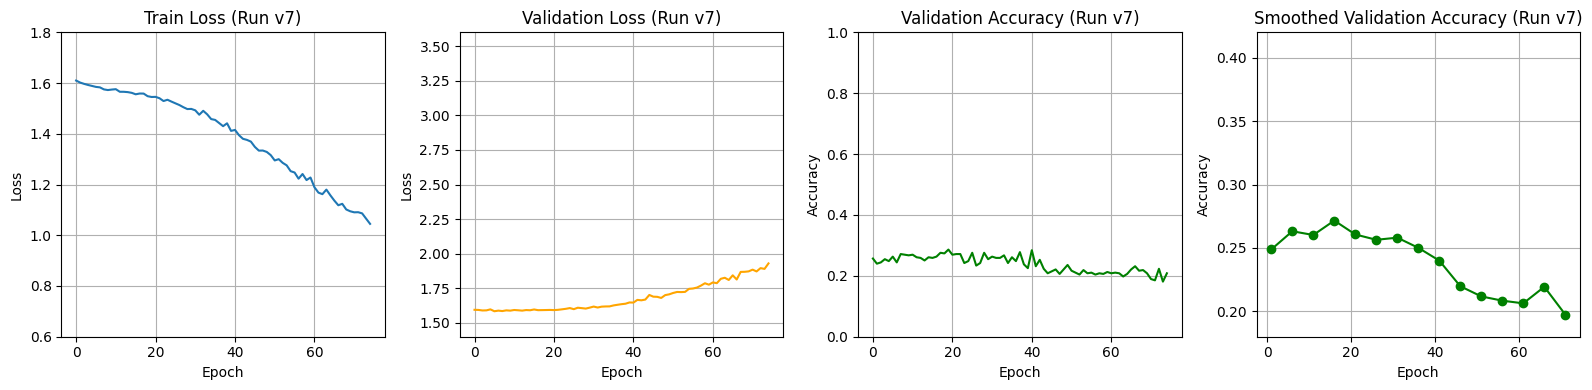

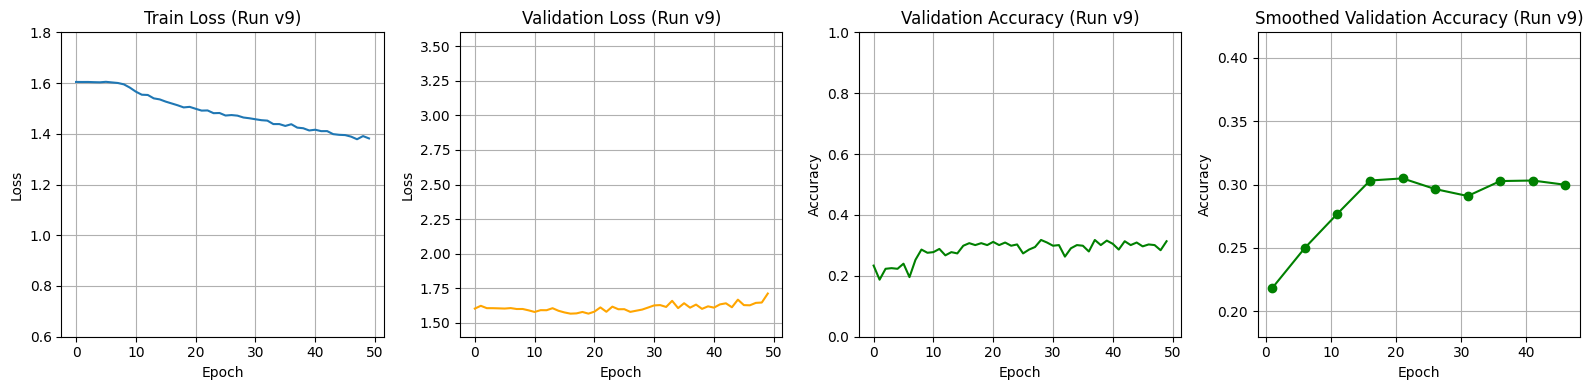

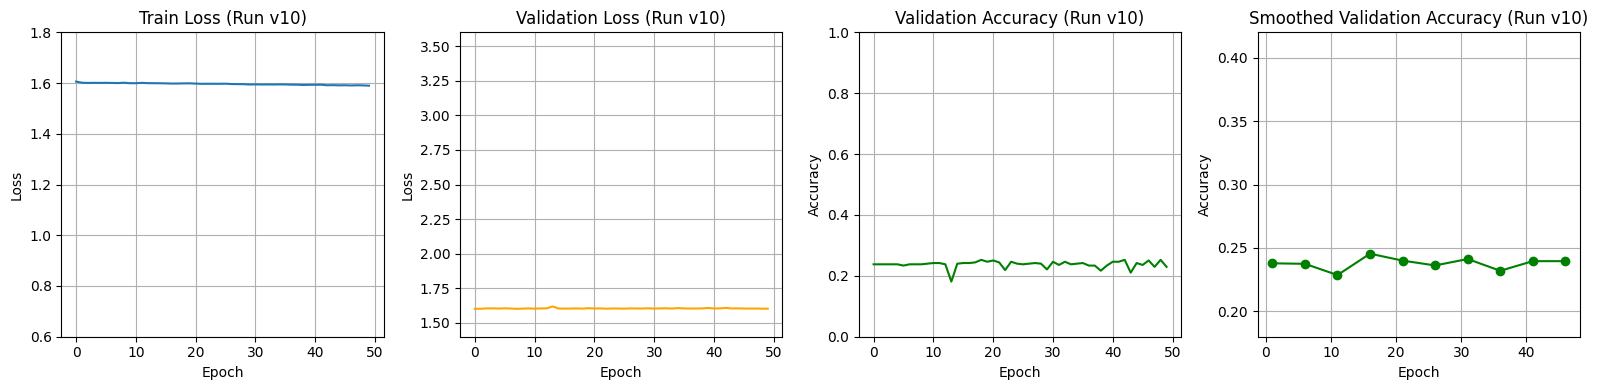

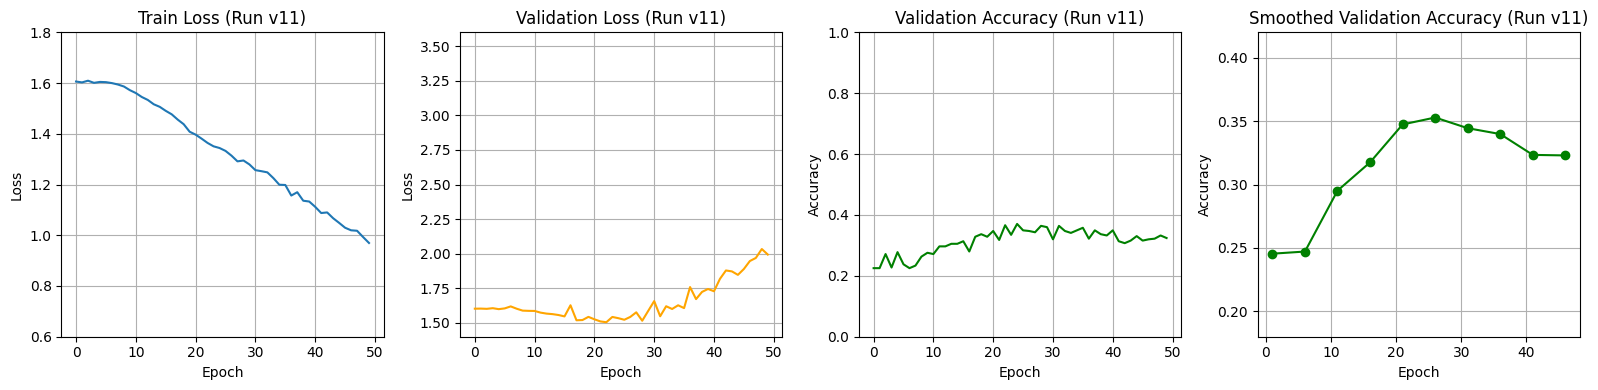

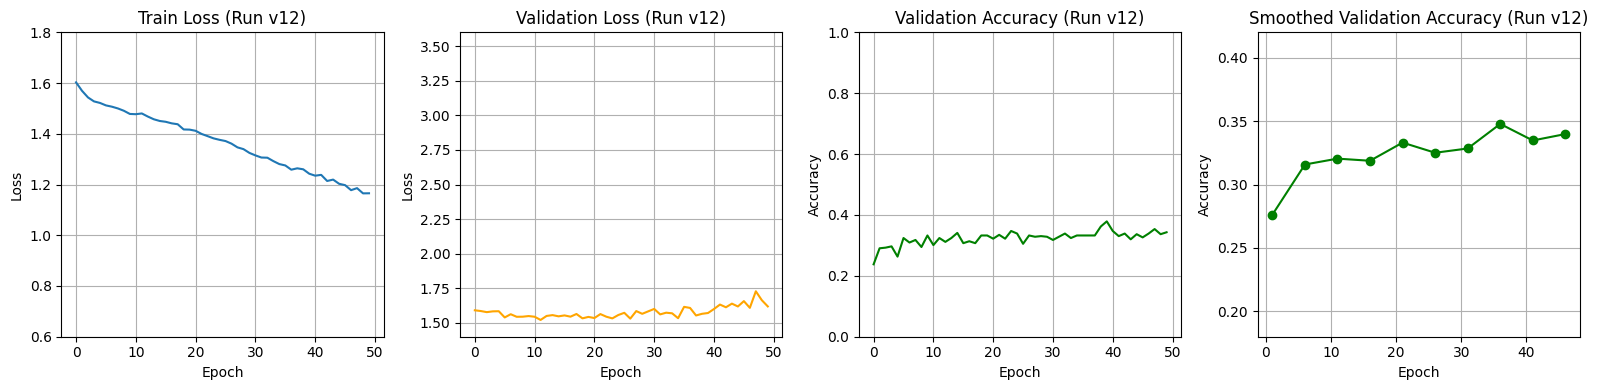

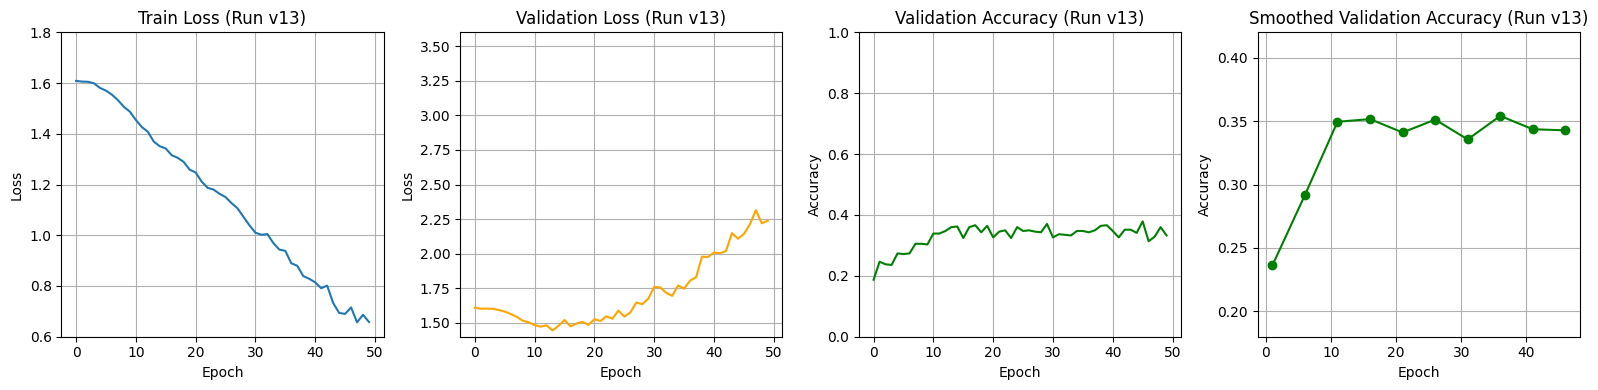

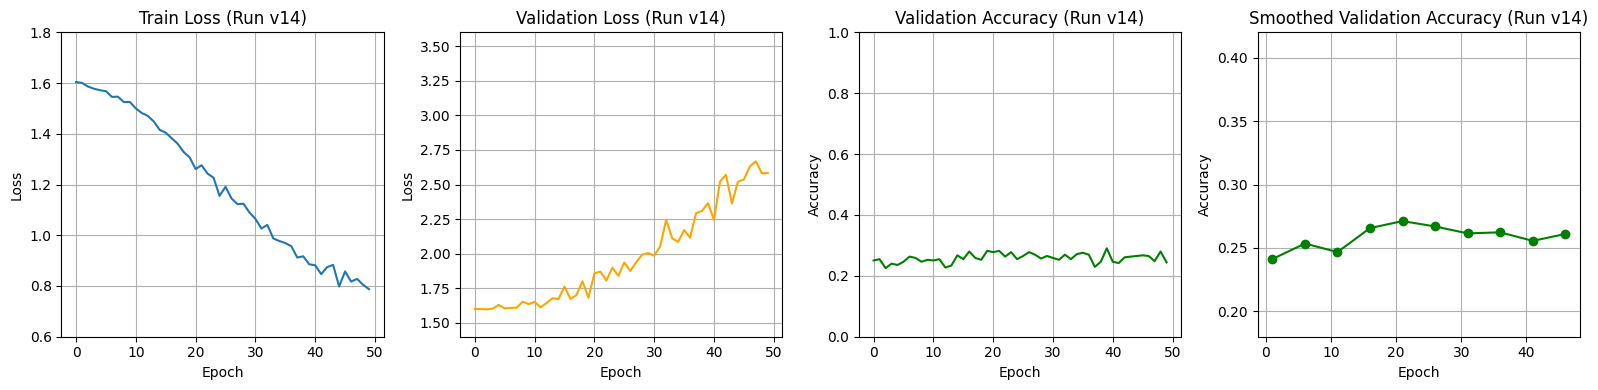

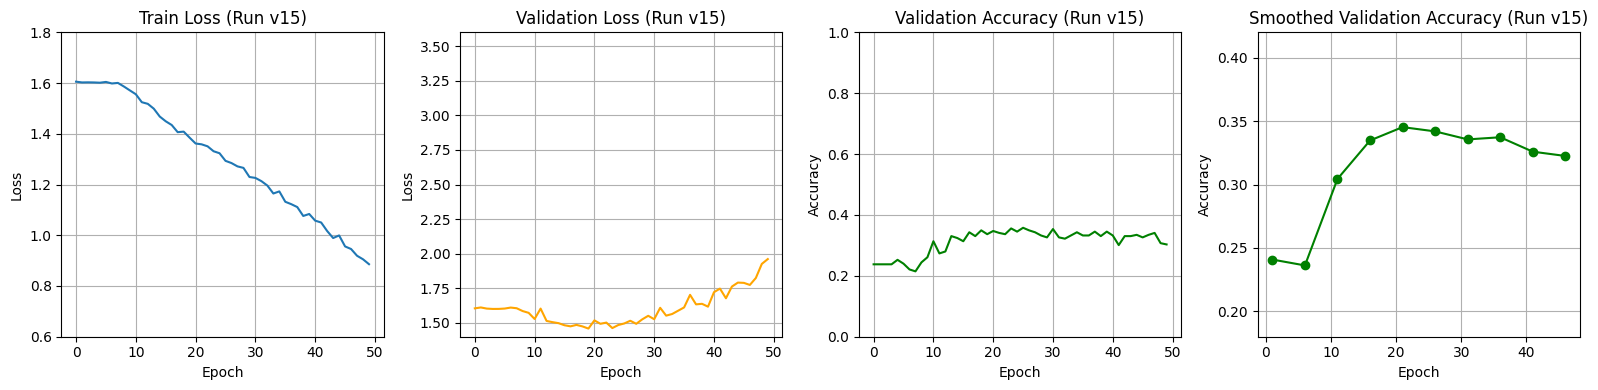

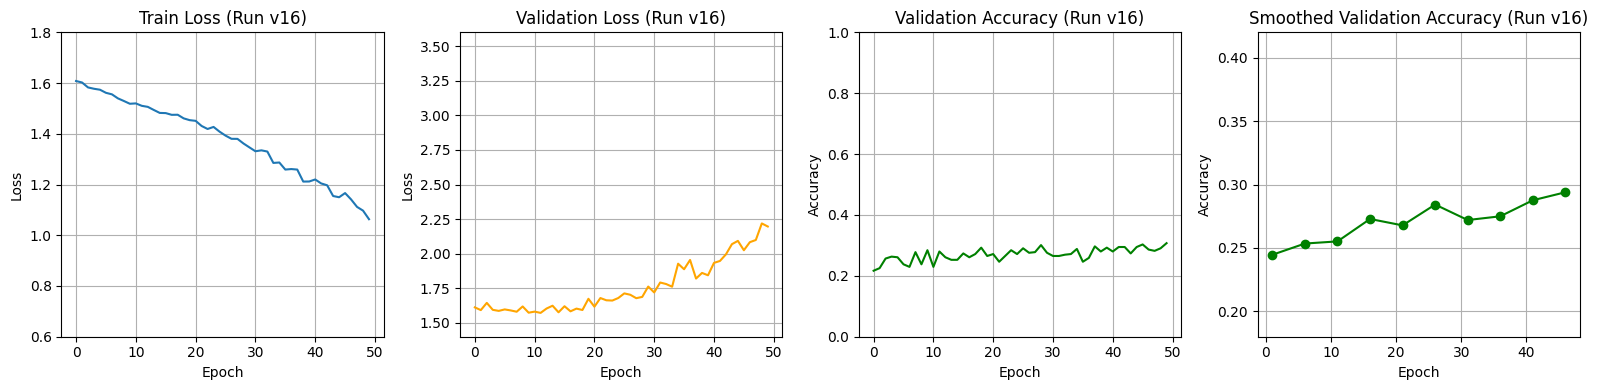

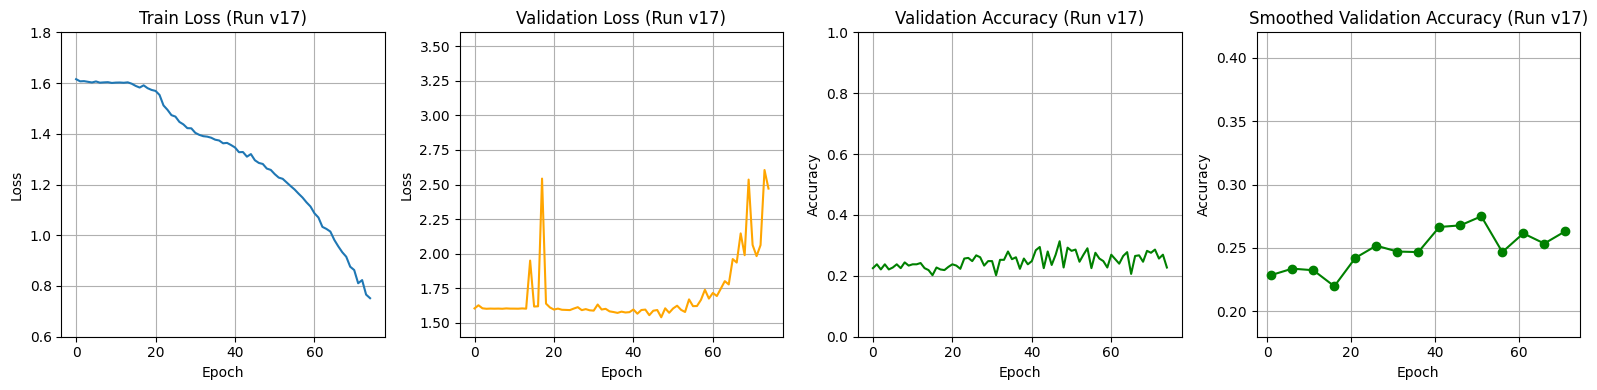

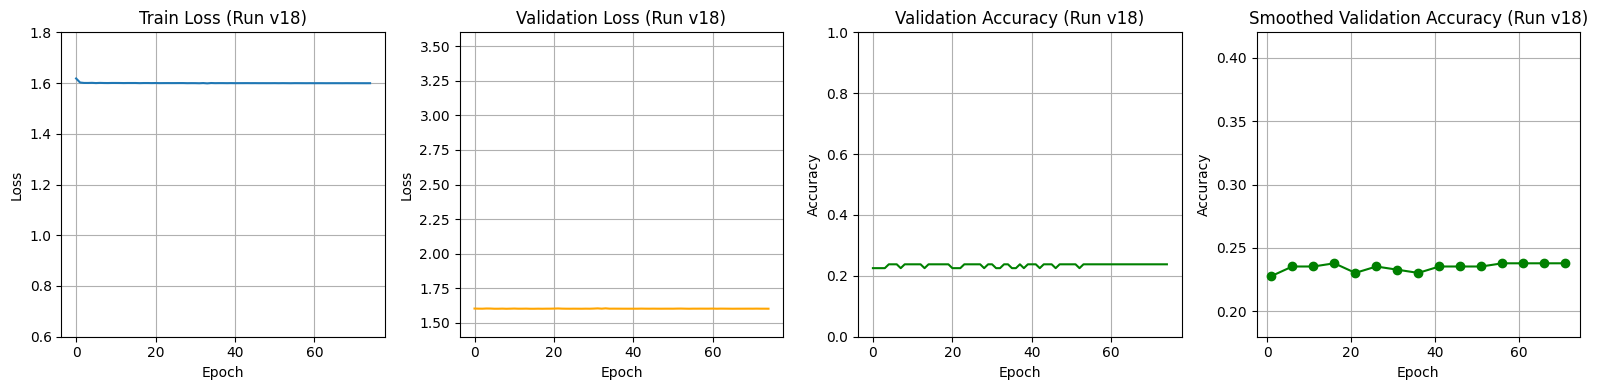

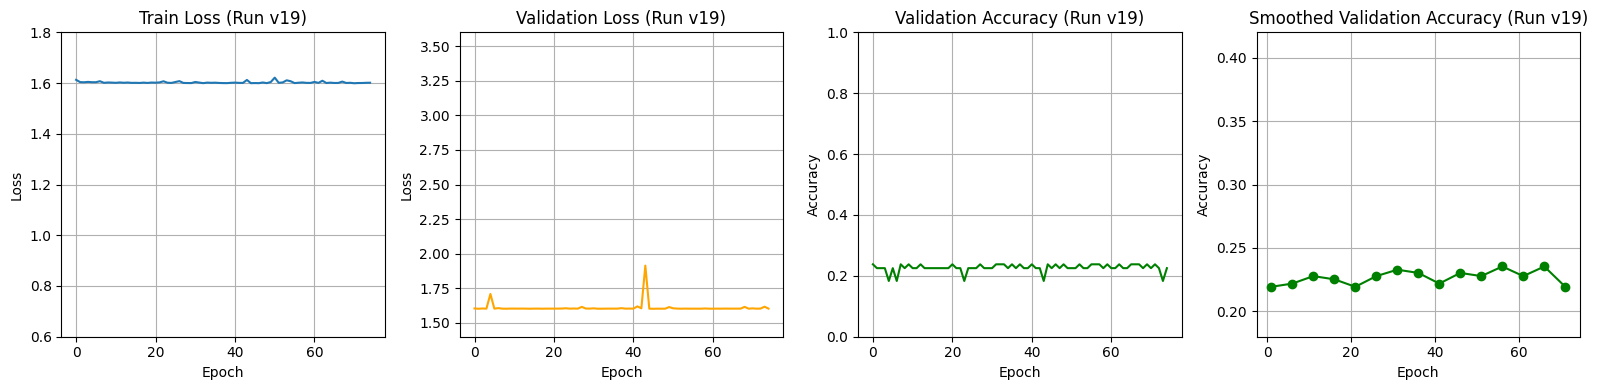

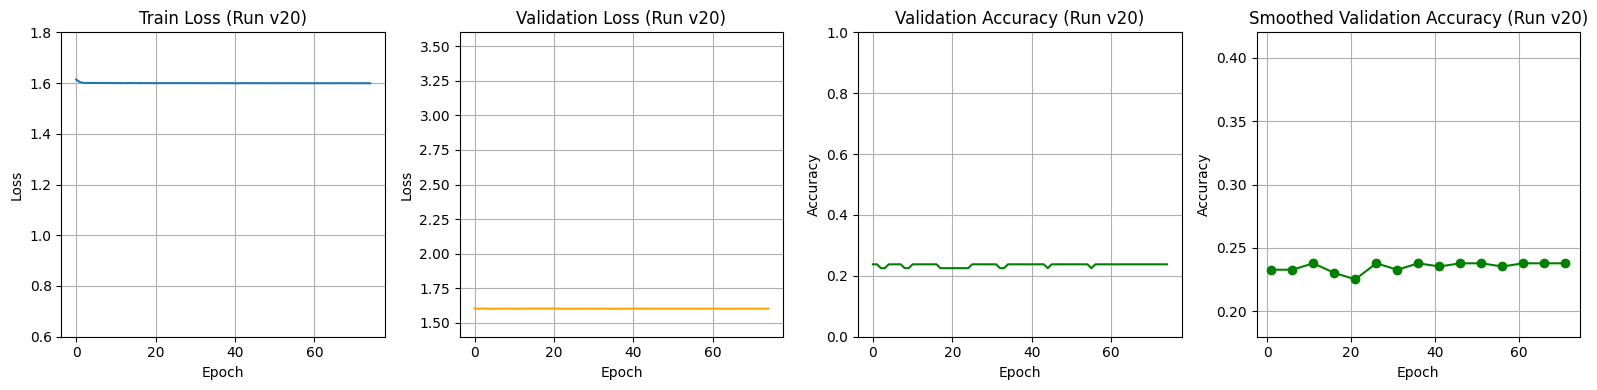

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Grouped average function
def grouped_average(values, group_size):
    return [np.mean(values[i:i + group_size]) for i in range(0, len(values), group_size)]

group_size = 5  # average over 5 epochs

histories = []
versions = []

# Sort by version number 
jsons = sorted(
    path.glob('*.json'),
    key=lambda f: int(re.search(r'v(\d+)', f.name).group(1))
)

# Read data and record version numbers
for json_file in jsons:
    version = int(re.search(r'v(\d+)', json_file.name).group(1))
    versions.append(version)
    with open(json_file, 'r') as file:
        histories.append(json.loads(file.read()))

# Plot each history {'loss': {'min': 0.07272758660838008, 'max': 1.6213791866430236}, 'val_loss': {'min': 1.43709717123132, 'max': 3.5515135719901636}, 'val_acc': {'min': 0.18105263157894738, 'max': 0.4105263157894737}}
for history, version in zip(histories, versions):
    val_acc = history['val_acc']
    val_acc_grouped = grouped_average(val_acc, group_size)
    val_acc_epochs = [i + 1 for i in range(0, len(val_acc), group_size)]

    plt.figure(figsize=(16, 4))

    # Loss
    plt.subplot(1, 4, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Train Loss (Run v{version})')  # Use real version number
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.ylim(0.6, 1.8)

    # Val loss
    plt.subplot(1, 4, 2)
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title(f'Validation Loss (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.ylim(1.4,3.6)

    plt.subplot(1, 4, 3)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0, 1.0)

    # Smoothed val accuracy
    plt.subplot(1, 4, 4)
    plt.plot(val_acc_epochs, val_acc_grouped, label='Val Acc (Avg/5)', color='green', marker='o')
    plt.title(f'Smoothed Validation Accuracy (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0.18, 0.42)
    
    plt.tight_layout()
    plt.show()


In [ ]:
for i, history_str in enumerate(histories):
    history = json.loads(history_str)  
    print(f"Training loss: {history['loss']}")
    print(f"Validation Accuracy: {history['val_acc']}")
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Train Loss (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title(f'Validation Accuracy (Run v{version})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Show the plots for this run
    plt.tight_layout()
    plt.show()

In [8]:
import json

# Find min and max for each key across all histories
stats = {}
for history in histories:
    for key, values in history.items():
        if isinstance(values, list) and all(isinstance(v, (int, float)) for v in values):
            if key not in stats:
                stats[key] = {"min": float("inf"), "max": float("-inf")}
            stats[key]["min"] = min(stats[key]["min"], min(values))
            stats[key]["max"] = max(stats[key]["max"], max(values))

print(stats)


{'loss': {'min': 0.5280927830264046, 'max': 1.1475556636759257}, 'val_loss': {'min': 0.8415678544455053, 'max': 1.1133653283222884}, 'val_acc': {'min': 0.5208333333333334, 'max': 0.6927083333333334}}
